## Library Imports

In [1]:
import keras
import numpy as np

import time

import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as tfl

# import misc

import pandas as pd

import datetime

import glob

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Conv1D, MaxPooling1D, Flatten, \
                                    Masking, LSTM, Softmax, Multiply, Layer, Concatenate, Lambda, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.model_selection import train_test_split

import tensorly as tl
from tensorly.decomposition import tucker

2025-03-02 21:05:14.630564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740978314.648939   37679 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740978314.654614   37679 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 21:05:14.673589: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import Data

In [2]:
# Mapping for string labels to integers
label_mapping = {"CN": 0, "MCI": 1, "Dementia": 2}

max_seq_length = 6

manifest = pd.read_csv("/home/mason/TFN_AD/AD_Patient_Manifest.csv")

In [3]:
# Load all data into memory. Not elegant, but works.
def load_all_data(manifest, target_size=(224, 224), demographic_columns=None, time_series_columns=None, label_mapping=None):
    image_data = []
    demographics_data = []
    time_series_data = []
    labels = []
    label_mapping = label_mapping or {}

    for _, row in manifest.iterrows():
        patient_path = row["path"]
        patient_df = pd.read_pickle(patient_path)

        # Load image data
        image_paths = [patient_df['image_path'].iloc[0]]
        for path in image_paths:
            img = load_img(path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            image_data.append(img_array)

        # Process demographics data
        if demographic_columns is None:
            raise ValueError("Please specify the demographics columns.")
        
        # Get first row of demographic data (since it doesn't change over time)
        demographics = patient_df[demographic_columns].iloc[0]
        demographics = demographics.values.astype(np.float32)  # Convert to NumPy array
        demographics_data.append(demographics)

        # Process time series data
        if time_series_columns is None:
            raise ValueError("Please specify the time series columns.")
        
        # Extract the relevant time series columns
        time_series = patient_df[time_series_columns].values  # Extract as NumPy array

        # Truncate or pad to max_seq_length
        if len(time_series) > max_seq_length:
            time_series = time_series[:max_seq_length, :]
        elif len(time_series) < max_seq_length:
            padding = np.zeros((max_seq_length - len(time_series), len(time_series_columns)))
            time_series = np.vstack([time_series, padding])
        time_series_data.append(time_series)

        # Load labels
        label_str = patient_df['DX'].iloc[0]
        label_int = label_mapping[label_str]
        labels.append(label_int)

    # Convert to numpy arrays
    image_data = np.array(image_data, dtype=np.float32)
    demographics_data = np.array(demographics_data, dtype=np.float32)
    time_series_data = np.array(time_series_data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return image_data, demographics_data, time_series_data, labels

In [4]:
# Demographic variables to extract
demographic_columns = ['AGE', 'PTEDUCAT', 'PTGENDER_encoded', 
                        'PTETHCAT_encoded', 'PTRACCAT_encoded', 'PTMARRY_encoded']
# Time series variables to extract
time_series_columns = ['Years_bl', 'ADAS11', 'ADAS13', 'ADASQ4']

# Load all data into memory
image_data, demographics_data, time_series_data, labels = load_all_data(manifest, target_size=(224, 224), demographic_columns=demographic_columns, 
                                                      time_series_columns=time_series_columns, label_mapping=label_mapping)

# Split the data
test_size = 0.2  # 20% of the data for testing

(image_train, image_test,
 demographics_train, demographics_test,
 time_train, time_test,
 labels_train, labels_test) = train_test_split(
    image_data, demographics_data, time_series_data, labels, test_size=test_size, random_state=42, stratify=labels
)

In [5]:
batch_size = 64

# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((image_train, demographics_train, time_train), labels_train))
# train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create testing (validation) dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((image_test, demographics_test, time_test), labels_test))
# test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

W0000 00:00:1740978322.108609   37679 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Visual Models

### Map Image Data

In [36]:
def extract_images_labels(data, label):
    images = data[0]  # Extract only images
    return images, label

# Modify dataset to keep only images and labels
image_train_dataset = train_dataset.map(extract_images_labels)
image_test_dataset = test_dataset.map(extract_images_labels)

# Preprocess images for VGG-16
def preprocess(image, label):
    # image = tf.squeeze(image, axis=0)  # Remove extra batch dimension if it exists
    image = tf.image.resize(image, (224, 224))  # Resize to VGG-16 input size
    image = preprocess_input(image)  # Normalize with VGG-16 preprocessing
    return image, label

image_train_dataset = image_train_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
image_test_dataset = image_test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

### VGG-16

In [6]:
def build_visual_embedder():
    # Load the VGG16 model without the top layers
    visual_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model to retain pretrained weights during training
    visual_base_model.trainable = False

    # Add a top for 3-way classification
    x = visual_base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(256, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization

    visual_base_features = Dense(16, activation='relu')(x) 

    # Define the final model
    visual_model = Model(inputs=visual_base_model.input, outputs=visual_base_features, name="VisualEmbedder")
    return visual_model

In [38]:
# Visual embedder
visual_embedder = build_visual_embedder()

# Outputs from embedders
visual_features = visual_embedder.output

# Add final classification layers
x = Dense(128, activation='relu')(visual_features)
x = Dropout(0.2)(x)
final_output = Dense(3, activation='softmax', name="final_output")(x)

# Define the combined model
visual_model = Model(inputs=visual_embedder.input, 
                       outputs=final_output, name="visualmodel")

In [39]:
# Early stopping to prevent redundant training.
vgg_early_stopping = EarlyStopping(monitor='accuracy', patience=60, restore_best_weights=True)

visual_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [40]:
# Train model
vgg_history = visual_model.fit(
    image_train_dataset, 
    validation_data=image_test_dataset, 
    epochs=120, 
    callbacks=[vgg_early_stopping])

Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 766ms/step - accuracy: 0.3642 - loss: 1.3593 - val_accuracy: 0.4286 - val_loss: 1.0835
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 749ms/step - accuracy: 0.3828 - loss: 1.0851 - val_accuracy: 0.3636 - val_loss: 1.0843
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - accuracy: 0.3761 - loss: 1.1304 - val_accuracy: 0.3896 - val_loss: 1.0868
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 746ms/step - accuracy: 0.4140 - loss: 1.1084 - val_accuracy: 0.4545 - val_loss: 1.0808
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - accuracy: 0.3832 - loss: 1.0788 - val_accuracy: 0.5065 - val_loss: 1.0671
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - accuracy: 0.3760 - loss: 1.0921 - val_accuracy: 0.4935 - val_loss: 1.0580
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 748ms/step - accuracy: 0.3206 - loss: 1.1397 - val_accuracy: 0.4675 - val_loss: 1.0683
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step - accuracy: 0.3918 - loss: 1.0946 - val_accu

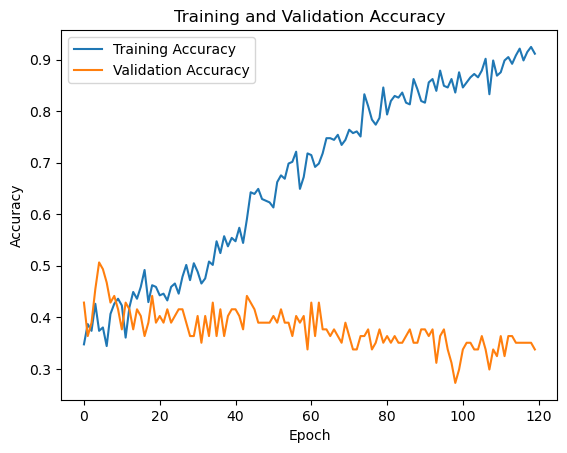

In [41]:
# Get training and validation accuracy and loss from the history object
train_acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']
train_loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

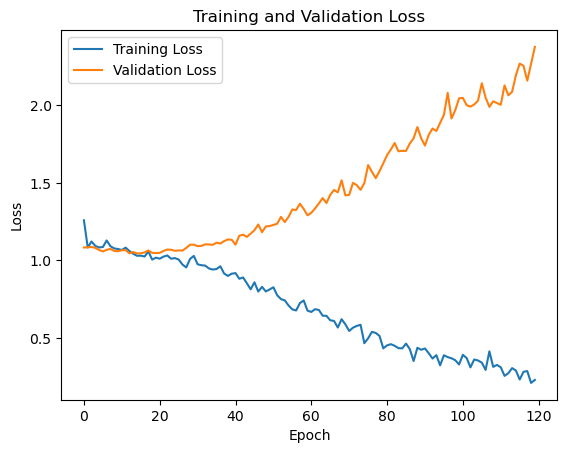

In [42]:
# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [43]:
# Get the final accuracy and loss for the last epoch
final_train_acc = vgg_history.history['accuracy'][-1]
final_val_acc = vgg_history.history['val_accuracy'][-1]
final_train_loss = vgg_history.history['loss'][-1]
final_val_loss = vgg_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)

Final Training Accuracy: 0.911475419998169
Final Validation Accuracy: 0.33766233921051025
Final Training Loss: 0.2287849336862564
Final Validation Loss: 2.377699851989746


## Demographic Models

In [29]:
def extract_demographics_labels(data, label):
    demographics = data[1]  # Extract only images
    return demographics, label

# Modify dataset to keep only images and labels
demographics_train_dataset = train_dataset.map(extract_demographics_labels)
demographics_test_dataset = test_dataset.map(extract_demographics_labels)


demographics_train_dataset = demographics_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
demographics_test_dataset = demographics_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
def build_demographics_embedder():
    # Input layer for demographics data
    input_layer = Input(shape=(6, ), name="demographics_input")

    x = Dense(16, activation='relu')(input_layer)
    x = Dropout(0.1)(x)
    x = Dense(4, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    # Classification head
    demographics_base_features = Dense(16, activation='relu')(x)
    
    # Define the model
    demographics_model = Model(inputs=input_layer, outputs=demographics_base_features, name="DemographicsEmbedder")
    return demographics_model

In [31]:
# demographic embedder
demographic_embedder = build_demographics_embedder()

# Outputs from embedders
demographic_features = demographic_embedder.output

# Add final classification layers
x = Dense(64, activation='relu')(demographic_features)
x = Dropout(0.2)(x)
final_output = Dense(3, activation='softmax', name="final_output")(x)

# Define the combined model
demographics_model = Model(inputs=demographic_embedder.input, 
                       outputs=final_output, name="demographic_model")

demographics_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [32]:
# Early stopping to prevent redundant training.
demographics_early_stopping = EarlyStopping(monitor='accuracy', patience=60, restore_best_weights=True)

demographics_history = demographics_model.fit(
    demographics_train_dataset, 
    validation_data=demographics_test_dataset, 
    epochs=120, 
    callbacks=[demographics_early_stopping])

Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3507 - loss: 2.7272 - val_accuracy: 0.2597 - val_loss: 1.6261
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3403 - loss: 2.3791 - val_accuracy: 0.3117 - val_loss: 1.4564
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3011 - loss: 2.5786 - val_accuracy: 0.3766 - val_loss: 1.3261
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3778 - loss: 1.9482 - val_accuracy: 0.4156 - val_loss: 1.2300
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3634 - loss: 1.8051 - val_accuracy: 0.3766 - val_loss: 1.1637
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3441 - loss: 1.7931 - val_accuracy: 0.3766 - val_loss: 1.1172
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3441 - loss: 1.8763 - val_accuracy: 0.3766 - val_loss: 1.0915
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3517 - loss: 1.7354 - val_accuracy: 0.3766 - 

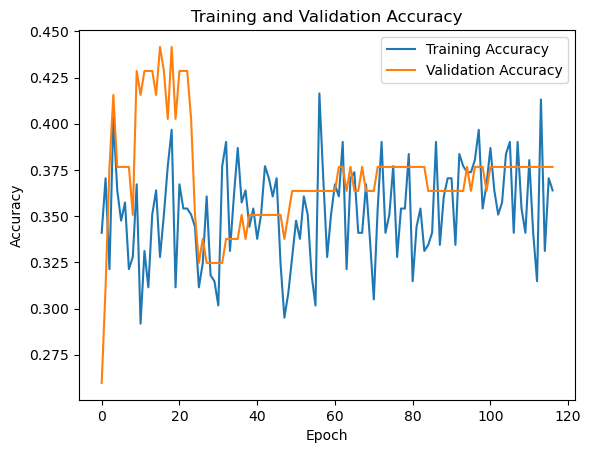

In [33]:
# Get training and validation accuracy and loss from the history object
train_acc = demographics_history.history['accuracy']
val_acc = demographics_history.history['val_accuracy']
train_loss = demographics_history.history['loss']
val_loss = demographics_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

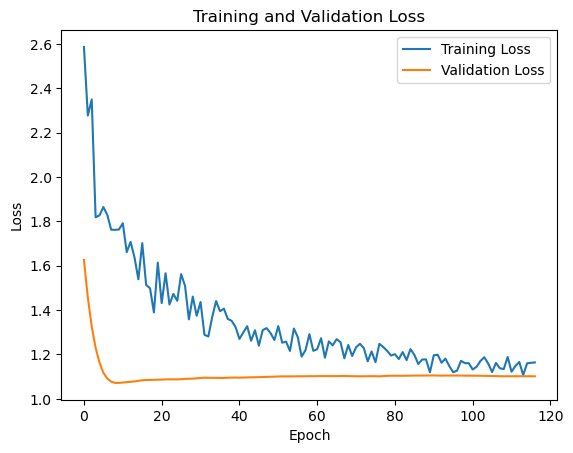

In [34]:
# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [35]:
# Get the final accuracy and loss for the last epoch
final_train_acc = demographics_history.history['accuracy'][-1]
final_val_acc = demographics_history.history['val_accuracy'][-1]
final_train_loss = demographics_history.history['loss'][-1]
final_val_loss = demographics_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)

Final Training Accuracy: 0.3639344274997711
Final Validation Accuracy: 0.37662336230278015
Final Training Loss: 1.1640067100524902
Final Validation Loss: 1.1014618873596191


## Time-Series Models

### LSTM

In [6]:
# === 1. Extract Time-Series Data and Labels ===
def extract_time_series_labels(data, label):
    time_series = data[2]  # Extract only time_train
    return time_series, label

# Modify dataset to keep only images and labels
time_train_dataset = train_dataset.map(extract_time_series_labels)
time_test_dataset = test_dataset.map(extract_time_series_labels)


time_train_dataset = time_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
time_test_dataset = time_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [8]:
max_seq_length = 6

def build_time_embedder():
    # Input layer for time series data (4 input variables)
    time_series_input = Input(shape=(max_seq_length, 4), name="time_series_input")
    masked_input = Masking(mask_value=0.0)(time_series_input)

    # Use the last hidden state
    x = LSTM(32, return_sequences=False)(masked_input)

    # Dense layer to create time series output
    time_base_features = Dense(16, activation="relu")(x)
    
    # Define the model
    time_model = Model(inputs=time_series_input, outputs=time_base_features, name="TimeSeriesEmbedder")
    return time_model

In [10]:
time_embedder = build_time_embedder()

time_features = time_embedder.output

lstm_hidden = Dense(64, activation='relu')(time_features)
x = Dropout(0.2)(time_features)
lstm_pred = Dense(3, activation='softmax', name="final_output")(x)

# Define the combined model
lstm_model = Model(inputs=time_embedder.input, outputs=lstm_pred, name="lstm_model")

# === 4. Compile & Train the Model ===
lstm_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Early stopping to prevent redundant training.
lstm_early_stopping = EarlyStopping(monitor='accuracy', patience=20, restore_best_weights=True)

# Train the LSTM model
lstm_history = lstm_model.fit(time_train_dataset, 
                              validation_data=time_test_dataset, 
                              epochs=120, 
                              callbacks=[lstm_early_stopping])

Epoch 1/120


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3864 - loss: 1.1114 - val_accuracy: 0.3636 - val_loss: 1.0761
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3907 - loss: 1.0959 - val_accuracy: 0.3636 - val_loss: 1.0583
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4069 - loss: 1.0660 - val_accuracy: 0.4026 - val_loss: 1.0424
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4408 - loss: 1.0565 - val_accuracy: 0.4156 - val_loss: 1.0278
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4564 - loss: 1.0331 - val_accuracy: 0.4286 - val_loss: 1.0139
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4804 - loss: 1.0121 - val_accuracy: 0.4286 - val_loss: 1.0010
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4553 - loss: 1.0213 - val_accuracy: 0.4675 - val_loss: 0.9889
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4609 - loss: 1.0155 - val_accuracy: 0.5325 - val_loss: 0.

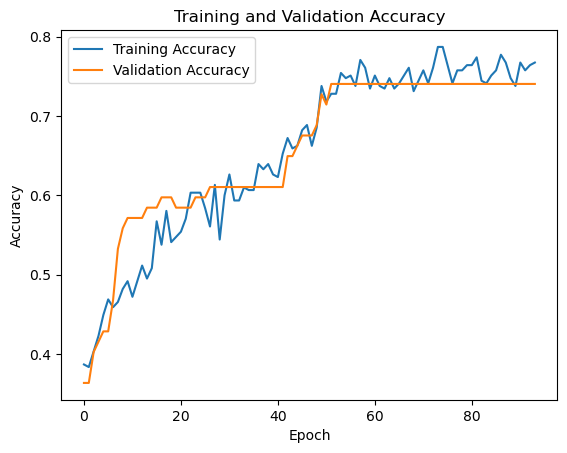

In [11]:
# Get training and validation accuracy and loss from the history object
lstm_train_acc = lstm_history.history['accuracy']
lstm_val_acc = lstm_history.history['val_accuracy']
lstm_train_loss = lstm_history.history['loss']
lstm_val_loss = lstm_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(lstm_train_acc, label='Training Accuracy')
plt.plot(lstm_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

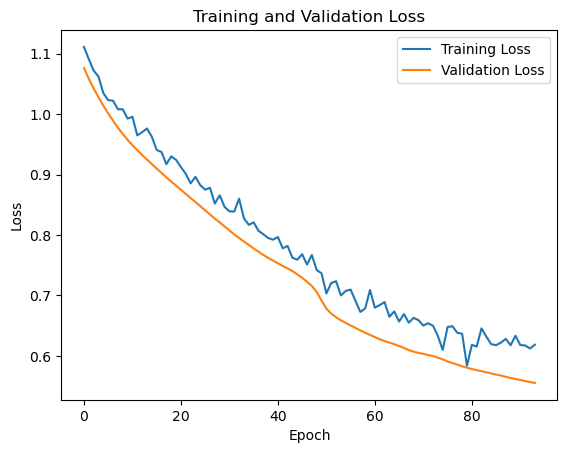

In [12]:
# Plot training and validation loss
plt.figure()
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [13]:
# Get the final accuracy and loss for the last epoch
lstm_final_train_acc = lstm_history.history['accuracy'][-1]
lstm_final_val_acc = lstm_history.history['val_accuracy'][-1]
lstm_final_train_loss = lstm_history.history['loss'][-1]
lstm_final_val_loss = lstm_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", lstm_final_train_acc)
print("Final Validation Accuracy:", lstm_final_val_acc)
print("Final Training Loss:", lstm_final_train_loss)
print("Final Validation Loss:", lstm_final_val_loss)

Final Training Accuracy: 0.7672131061553955
Final Validation Accuracy: 0.7402597665786743
Final Training Loss: 0.618599534034729
Final Validation Loss: 0.5553852915763855


# Joint Visual-TimeSeries

In [6]:
def extract_images_time_labels(data, label):
    images = data[0]  # Extract only images
    time = data[2]
    return (images, time), label

# Modify dataset to keep only images and labels
multimodal_train_dataset = train_dataset.map(extract_images_time_labels)
multimodal_test_dataset = test_dataset.map(extract_images_time_labels)

# Preprocess images for VGG-16
def preprocess(data, label):
    data[0] = tf.image.resize(data[0], (224, 224))  # Resize to VGG-16 input size
    data[0] = preprocess_input(data[0])  # Normalize with VGG-16 preprocessing
    return (data[0], data[1]), label

multimodal_train_dataset = multimodal_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
multimodal_test_dataset = multimodal_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
num_classes = 3

visual_embedder = build_visual_embedder()
time_embedder = build_time_embedder()

visual_features = visual_embedder.output
time_features = time_embedder.output

# Concatenate VGG and LSTM outputs
combined = Concatenate()([visual_features, time_features])

# Fully connected classifier
x = Dense(128, activation="relu")(combined)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(combined)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation="softmax")(x)  # Adjust num_classes

# Define full model
vgg_lstm_model = Model(inputs=[visual_embedder.input, time_embedder.input], outputs=output, name="vgg_lstm_joint")

# === 4. Compile & Train the Model ===
vgg_lstm_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Early stopping to prevent redundant training.
vgg_lstm_early_stopping = EarlyStopping(monitor='accuracy', patience=30, restore_best_weights=True)

# Train the LSTM model
joint_history = vgg_lstm_model.fit(multimodal_train_dataset, 
                              validation_data=multimodal_test_dataset, 
                              epochs=120, 
                              callbacks=[vgg_lstm_early_stopping])

Epoch 1/120


/home/mason/.conda/envs/LOSresearch/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_33', 'time_series_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 949ms/step - accuracy: 0.3361 - loss: 1.2683 - val_accuracy: 0.3506 - val_loss: 1.0889
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 899ms/step - accuracy: 0.3728 - loss: 1.1421 - val_accuracy: 0.4545 - val_loss: 1.0816
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 893ms/step - accuracy: 0.4059 - loss: 1.1037 - val_accuracy: 0.4156 - val_loss: 1.0821
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 887ms/step - accuracy: 0.4088 - loss: 1.0782 - val_accuracy: 0.5195 - val_loss: 1.0690
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 901ms/step - accuracy: 0.4825 - loss: 1.0611 - val_accuracy: 0.5325 - val_loss: 1.0528
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 900ms/step - accuracy: 0.5337 - loss: 1.0501 - val_accuracy: 0.5714 - val_loss: 1.0398
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 894ms/step - accuracy: 0.5417 - loss: 1.0390 - val_accuracy: 0.5325 - val_loss: 1.0297
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 905ms/step - accuracy: 0.5267 - loss: 1.0239 - val_accuracy: 0.584

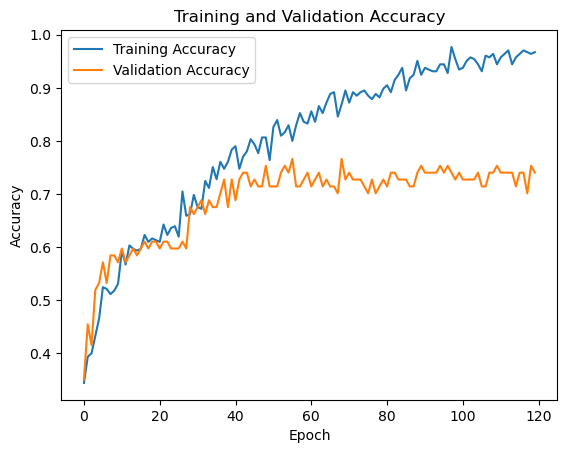

In [12]:
# Get training and validation accuracy and loss from the history object
lstm_train_acc = joint_history.history['accuracy']
lstm_val_acc = joint_history.history['val_accuracy']
lstm_train_loss = joint_history.history['loss']
lstm_val_loss = joint_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(lstm_train_acc, label='Training Accuracy')
plt.plot(lstm_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

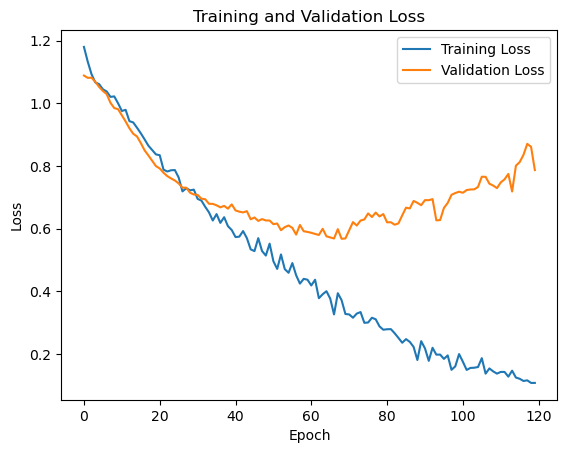

In [13]:
# Plot training and validation loss
plt.figure()
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [14]:
# Get the final accuracy and loss for the last epoch
lstm_final_train_acc = joint_history.history['accuracy'][-1]
lstm_final_val_acc = joint_history.history['val_accuracy'][-1]
lstm_final_train_loss = joint_history.history['loss'][-1]
lstm_final_val_loss = joint_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", lstm_final_train_acc)
print("Final Validation Accuracy:", lstm_final_val_acc)
print("Final Training Loss:", lstm_final_train_loss)
print("Final Validation Loss:", lstm_final_val_loss)

Final Training Accuracy: 0.9672130942344666
Final Validation Accuracy: 0.7402597665786743
Final Training Loss: 0.10783686488866806
Final Validation Loss: 0.7872161269187927


# Joint Visual-Demographics

In [18]:
def extract_images_demographics_labels(data, label):
    images = data[0]  # Extract only images
    demographics = data[1]
    return (images, demographics), label

# Modify dataset to keep only images and labels
visualdemographics_train_dataset = train_dataset.map(extract_images_demographics_labels)
visualdemographics_test_dataset = test_dataset.map(extract_images_demographics_labels)

# Preprocess images for VGG-16
def preprocess(data, label):
    data[0] = tf.image.resize(data[0], (224, 224))  # Resize to VGG-16 input size
    data[0] = preprocess_input(data[0])  # Normalize with VGG-16 preprocessing
    return (data[0], data[1]), label

visualdemographics_train_dataset = visualdemographics_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
visualdemographics_test_dataset = visualdemographics_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
num_classes = 3

visual_embedder = build_visual_embedder()
demographics_embedder = build_demographics_embedder()

visual_features = visual_embedder.output
demographics_features = demographics_embedder.output

# Concatenate VGG and LSTM outputs
combined = Concatenate()([visual_features, demographics_features])

# Fully connected classifier
x = Dense(128, activation="relu")(combined)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(combined)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation="softmax")(x)  # Adjust num_classes

# Define full model
vgg_demographics_model = Model(inputs=[visual_embedder.input, demographics_embedder.input], outputs=output, name="vgg_demographics_joint")

# === 4. Compile & Train the Model ===
vgg_demographics_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Early stopping to prevent redundant training.
vgg_demographics_early_stopping = EarlyStopping(monitor='accuracy', patience=30, restore_best_weights=True)

# Train the LSTM model
joint_history = vgg_demographics_model.fit(visualdemographics_train_dataset, 
                              validation_data=visualdemographics_test_dataset, 
                              epochs=120, 
                              callbacks=[vgg_demographics_early_stopping])

Epoch 1/120


/home/mason/.conda/envs/LOSresearch/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_32', 'demographics_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 774ms/step - accuracy: 0.3928 - loss: 1.4381 - val_accuracy: 0.4026 - val_loss: 1.0592
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.3211 - loss: 1.1436 - val_accuracy: 0.3506 - val_loss: 1.0619
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 751ms/step - accuracy: 0.3773 - loss: 1.1180 - val_accuracy: 0.3636 - val_loss: 1.0579
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 747ms/step - accuracy: 0.3762 - loss: 1.1745 - val_accuracy: 0.3506 - val_loss: 1.0750
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - accuracy: 0.4066 - loss: 1.0913 - val_accuracy: 0.3377 - val_loss: 1.0800
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - accuracy: 0.3788 - loss: 1.1148 - val_accuracy: 0.2987 - val_loss: 1.0654
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.4200 - loss: 1.0926 - val_accuracy: 0.4156 - val_loss: 1.0516
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 740ms/step - accuracy: 0.3629 - loss: 1.1118 - val_accuracy: 0.4545

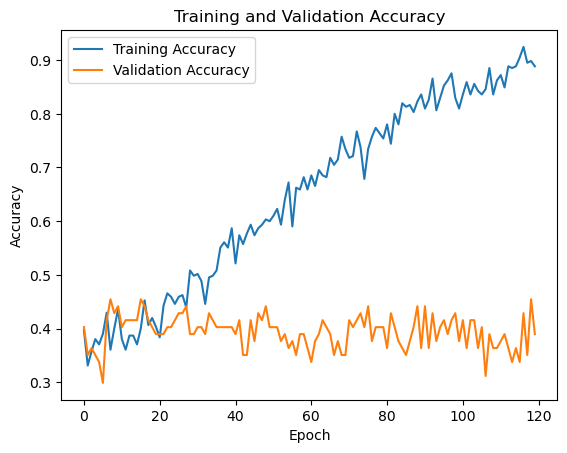

In [20]:
# Get training and validation accuracy and loss from the history object
lstm_train_acc = joint_history.history['accuracy']
lstm_val_acc = joint_history.history['val_accuracy']
lstm_train_loss = joint_history.history['loss']
lstm_val_loss = joint_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(lstm_train_acc, label='Training Accuracy')
plt.plot(lstm_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

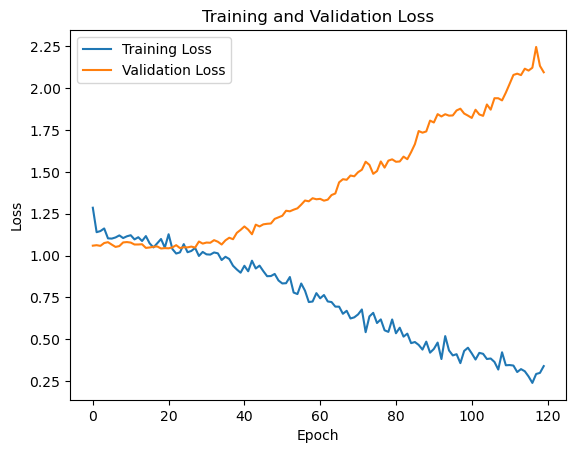

In [21]:
# Plot training and validation loss
plt.figure()
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [22]:
# Get the final accuracy and loss for the last epoch
lstm_final_train_acc = joint_history.history['accuracy'][-1]
lstm_final_val_acc = joint_history.history['val_accuracy'][-1]
lstm_final_train_loss = joint_history.history['loss'][-1]
lstm_final_val_loss = joint_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", lstm_final_train_acc)
print("Final Validation Accuracy:", lstm_final_val_acc)
print("Final Training Loss:", lstm_final_train_loss)
print("Final Validation Loss:", lstm_final_val_loss)

Final Training Accuracy: 0.88852459192276
Final Validation Accuracy: 0.3896103799343109
Final Training Loss: 0.33985427021980286
Final Validation Loss: 2.0948398113250732


# LSTM-Demographics

In [9]:
def extract_demographics_labels_time(data, label):
    demographics = data[1]  # Extract only images
    tine = data[2]
    return (demographics, tine), label

# Modify dataset to keep only images and labels
lstmdemographics_train_dataset = train_dataset.map(extract_demographics_labels_time)
lstmdemographics_test_dataset = test_dataset.map(extract_demographics_labels_time)

lstmdemographics_train_dataset = lstmdemographics_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
lstmdemographics_test_dataset = lstmdemographics_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
num_classes = 3

demographics_embedder = build_demographics_embedder()
time_embedder = build_time_embedder()

demographics_features = demographics_embedder.output
time_features = time_embedder.output

# Concatenate VGG and LSTM outputs
combined = Concatenate()([demographics_features, time_features])

# Fully connected classifier
x = Dense(128, activation="relu")(combined)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(combined)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation="softmax")(x)  # Adjust num_classes

# Define full model
lstm_demographics_model = Model(inputs=[demographics_embedder.input, time_embedder.input], outputs=output, name="lstm_demographics_joint")

# === 4. Compile & Train the Model ===
lstm_demographics_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Early stopping to prevent redundant training.
lstm_demographics_early_stopping = EarlyStopping(monitor='accuracy', patience=30, restore_best_weights=True)

# Train the LSTM model
joint_history = lstm_demographics_model.fit(lstmdemographics_train_dataset, 
                              validation_data=lstmdemographics_test_dataset, 
                              epochs=200, 
                              callbacks=[lstm_demographics_early_stopping])

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3352 - loss: 1.1886 - val_accuracy: 0.4026 - val_loss: 1.0816
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3480 - loss: 1.1485 - val_accuracy: 0.4286 - val_loss: 1.0731
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4134 - loss: 1.1459 - val_accuracy: 0.4935 - val_loss: 1.0646
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4450 - loss: 1.1075 - val_accuracy: 0.5455 - val_loss: 1.0558
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4707 - loss: 1.1533 - val_accuracy: 0.5974 - val_loss: 1.0461
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4830 - loss: 1.0957 - val_accuracy: 0.6234 - val_loss: 1.0359
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4394 - loss: 1.1330 - val_accuracy: 0.6494 - val_loss: 1.0252
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5225 - loss: 1.0569 - val_accuracy: 0.6623 - 

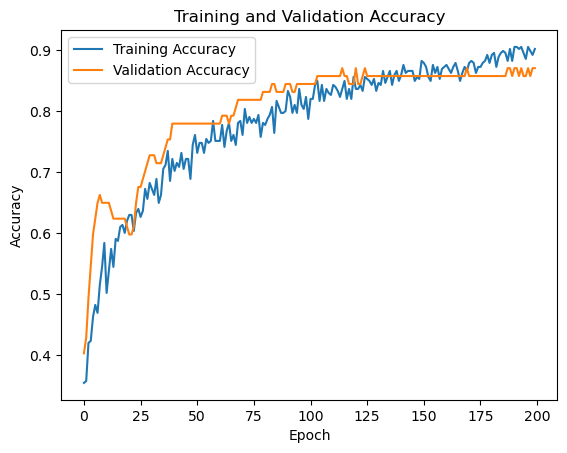

In [15]:
# Get training and validation accuracy and loss from the history object
lstm_train_acc = joint_history.history['accuracy']
lstm_val_acc = joint_history.history['val_accuracy']
lstm_train_loss = joint_history.history['loss']
lstm_val_loss = joint_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(lstm_train_acc, label='Training Accuracy')
plt.plot(lstm_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

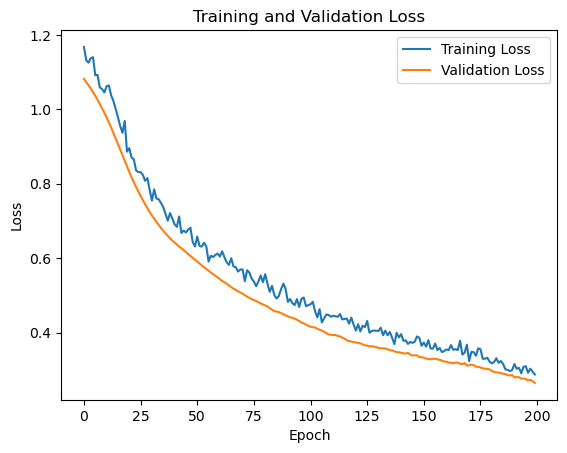

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [17]:
# Get the final accuracy and loss for the last epoch
lstm_final_train_acc = joint_history.history['accuracy'][-1]
lstm_final_val_acc = joint_history.history['val_accuracy'][-1]
lstm_final_train_loss = joint_history.history['loss'][-1]
lstm_final_val_loss = joint_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", lstm_final_train_acc)
print("Final Validation Accuracy:", lstm_final_val_acc)
print("Final Training Loss:", lstm_final_train_loss)
print("Final Validation Loss:", lstm_final_val_loss)

Final Training Accuracy: 0.9016393423080444
Final Validation Accuracy: 0.8701298832893372
Final Training Loss: 0.28714340925216675
Final Validation Loss: 0.2645571231842041


# Fusion Network Concat

In [11]:
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
# Visual embedder
visual_embedder = build_visual_embedder()

# Demographics embedder
demographics_embedder = build_demographics_embedder()

# Time Series Embedder
time_embedder = build_time_embedder()

# Outputs from embedders
visual_features = visual_embedder.output
demographics_features = demographics_embedder.output
time_features = time_embedder.output

# Concatenate individual outputs
combined = Concatenate()([visual_features, demographics_features, time_features])

# Add final classification layers
x = Dense(128, activation='relu')(combined)
x = Dense(64, activation='relu')(x)
final_output = Dense(3, activation='softmax', name="final_output")(x)

# Define the combined model
combined_model = Model(inputs=[visual_embedder.input, demographics_embedder.input, time_embedder.input], 
                       outputs=final_output, name="CombinedModel")

In [ ]:
# === 4. Compile & Train the Model ===
combined_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Early stopping to prevent redundant training.
joint_early_stopping = EarlyStopping(monitor='accuracy', patience=30, restore_best_weights=True)

# Train the LSTM model
joint_history = combined_model.fit(train_dataset, 
                              validation_data=test_dataset, 
                              epochs=200, 
                              callbacks=[joint_early_stopping])

Epoch 1/200


/home/mason/.conda/envs/LOSresearch/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'demographics_input', 'time_series_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4009 - loss: 1.6445 - val_accuracy: 0.3896 - val_loss: 1.3772
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3798 - loss: 1.3796 - val_accuracy: 0.3896 - val_loss: 1.1899
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3583 - loss: 1.2557 - val_accuracy: 0.4286 - val_loss: 1.1029
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3435 - loss: 1.1219 - val_accuracy: 0.3506 - val_loss: 1.1251
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3748 - loss: 1.1302 - val_accuracy: 0.3506 - val_loss: 1.1424
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3766 - loss: 1.1267 - val_accuracy: 0.3636 - val_loss: 1.1105
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3673 - loss: 1.1053 - val_accuracy: 0.4156 - val_loss: 1.0942
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4196 - loss: 1.0771 - val_accuracy: 0.4286 - val_loss: 1.0947
Epoch 9/200
5/5 ━━━

In [ ]:
# Get training and validation accuracy and loss from the history object
lstm_train_acc = joint_history.history['accuracy']
lstm_val_acc = joint_history.history['val_accuracy']
lstm_train_loss = joint_history.history['loss']
lstm_val_loss = joint_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(lstm_train_acc, label='Training Accuracy')
plt.plot(lstm_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
# Get the final accuracy and loss for the last epoch
lstm_final_train_acc = joint_history.history['accuracy'][-1]
lstm_final_val_acc = joint_history.history['val_accuracy'][-1]
lstm_final_train_loss = joint_history.history['loss'][-1]
lstm_final_val_loss = joint_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", lstm_final_train_acc)
print("Final Validation Accuracy:", lstm_final_val_acc)
print("Final Training Loss:", lstm_final_train_loss)
print("Final Validation Loss:", lstm_final_val_loss)